In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

Using TensorFlow backend.


In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [3]:
# Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian DCTR Example.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

We then sample from normal distributions with this $\mu$ value

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [4]:
# Either load or train DCTR

def get_dctr(load=False, n_data_points=10**6, mu_min=-2, mu_max=2):
    if load:
        json_file = open('1d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("1d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:
        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

        X0 = [(np.random.normal(0, 1), mu)
              for mu in mu_values]  # Note the zero in normal(0, 1)
        X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((2, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping],
                       verbose=0)
        print("Trained DCTR Model")

    return dctr_model

### Loading Model

In [5]:
mu_min = -2
mu_max = 2

dctr_model = get_dctr(n_data_points = 10**7, mu_min=mu_min, mu_max=mu_max)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model


### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [6]:
# from NN (DCTR)
def reweight(events, param):
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param):
    mu0 = 0.0
    weights = K.exp(-(0.5 * (events - param)**2) + (0.5 * (events - mu0)**2))
    return weights

## Validate DCTR for any $\mu$

### Validate for Truth Level

In [7]:
mu1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
X0_val_T = np.random.normal(0, 1, 10**6)
X1_val_T = np.random.normal(mu1, 1, 10**6)

In [8]:
weights = reweight(
    K.expand_dims(tf.convert_to_tensor(X0_val_T, dtype=tf.float32)), mu1)
analytical_weights = analytical_reweight(X0_val_T, mu1)

weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

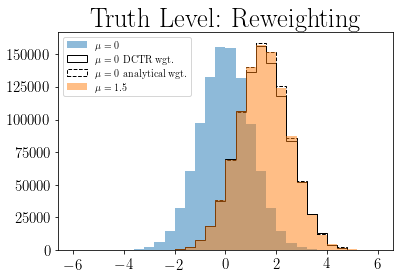

In [9]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_T, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Truth Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-Truth-Level:Reweighting.png")
plt.show()

### Validate for Detector Level

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [10]:
# Generate detector level by smearing truth

epsilon_val = 0.5  # Smearing width

X0_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X0_val_T])  # Detector smearing
X1_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X1_val_T])  # Detector smearing

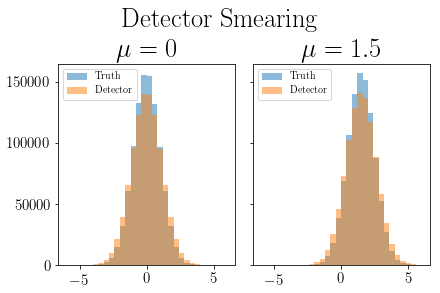

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$')
axs[0].hist(X0_val_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')
axs[1].set_title('$\mu={}$'.format(mu1))
axs[1].hist(X1_val_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')
fig.show()

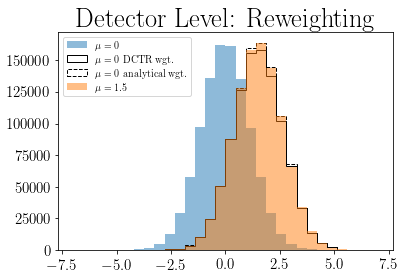

In [12]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_D, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-Detector-Level:Reweighting.png")
plt.show()

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [13]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
epsilon = sigma / 2  # Smearing width

theta0_T = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta0_T])  # Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis=1)

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta1_T])  # Detector smearing
theta1 = np.stack([theta1_T, theta1_D], axis=1)

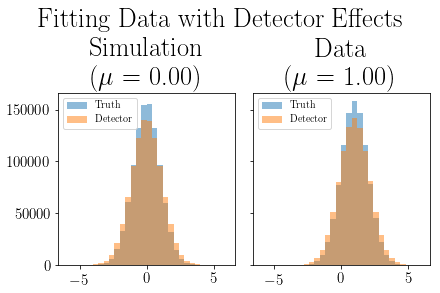

In [14]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc = 'upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc = 'upper left')

# fig.savefig("GaussianAltFit-1D-Fitting-Data-with-Detector-Effects.png")
plt.show()

In [15]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, 0]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
X_train_theta[:, 0][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                               axis=1)
X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.stack(
    [y_train_theta, X_train_theta[:, 0]], axis=1)

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [16]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas = np.linspace(-2, 2, 21)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


### Truth Level Scan

In [17]:
def my_loss_wrapper_T(inputs,
                      val=0.,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = val

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [18]:
lvals_T = []
vlvals_T = []

for theta in thetas:
    print("Testing theta = ", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_T(myinputs,
                                         theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_T),
                        y_train_T,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_T), y_test_T),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T += [min_lval]
    vlvals_T += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_T)

Testing theta =  -2.0
loss:  0.16332320460677147
val_loss:  0.1623212288469076


Testing theta =  -1.8
loss:  0.19434249484539032
val_loss:  0.19333320008218288


Testing theta =  -1.6
loss:  0.2291477932482958
val_loss:  0.22820982763171196


Testing theta =  -1.4
loss:  0.26744856625795366
val_loss:  0.2665673416107893


Testing theta =  -1.2
loss:  0.30875542405247686
val_loss:  0.30795285299420355


Testing theta =  -1.0
loss:  0.35249961906671523
val_loss:  0.3518231975734234


Testing theta =  -0.7999999999999998
loss:  0.3986014976799488
val_loss:  0.3979678714573383


Testing theta =  -0.5999999999999999
loss:  0.4452906675934792
val_loss:  0.44480460250377657


Testing theta =  -0.3999999999999999
loss:  0.4902941457331181
val_loss:  0.4899213627278805


Testing theta =  -0.19999999999999996
loss:  0.5351787229776382
val_loss:  0.534952096760273


Testing theta =  0.0
loss:  0.5768823358416557
val_loss:  0.5768018417358398


Testing theta =  0.20000000000000018
loss:  0.612404

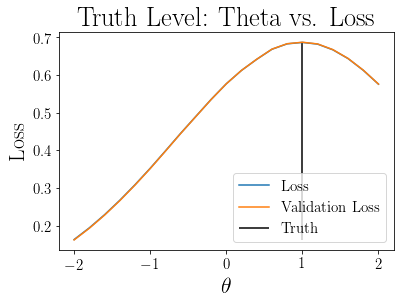

In [19]:
plt.title("Truth Level: Theta vs. Loss")
plt.plot(thetas, lvals_T, label='Loss')
plt.plot(thetas, vlvals_T, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T),
           ymax=np.max(lvals_T),
           label='Truth')
plt.legend()
# plt.savefig("GaussianAltFit-1D-Truth-Level:-Theta-vs-Loss.png")
plt.show()

In [20]:
f = sp.interpolate.interp1d(thetas, lvals_T, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999918813868


### Detector Level Scan

In [21]:
def my_loss_wrapper_D(val=0,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1], axis=1)  # sim event truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        theta_prime = val

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + (weights) * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")
        return K.mean(t_loss)

    return my_loss

In [22]:
lvals_D = []
vlvals_D = []

for theta in thetas:
    print("Testing theta = ", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper_D(theta,
                                         loss='categorical_crossentropy',
                                         batch_size=batch_size),
                  metrics=['accuracy'])

    history = model.fit(np.array(X_train_D),
                        y_train_D,
                        epochs=100,
                        batch_size=batch_size,
                        validation_data=(np.array(X_test_D), y_test_D),
                        verbose=0,
                        callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D += [min_lval]
    vlvals_D += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_D)

Testing theta =  -2.0
loss:  0.21419638109207154
val_loss:  0.2132698617875576


Testing theta =  -1.8
loss:  0.24719564965367316
val_loss:  0.24629620726406573


Testing theta =  -1.6
loss:  0.28278952264785767
val_loss:  0.2819377224743366


Testing theta =  -1.4
loss:  0.3204415858089924
val_loss:  0.3196339932382107


Testing theta =  -1.2
loss:  0.36009589809179304
val_loss:  0.3593396014273167


Testing theta =  -1.0
loss:  0.4010799370110035
val_loss:  0.4004119039475918


Testing theta =  -0.7999999999999998
loss:  0.4432377128303051
val_loss:  0.4425959376990795


Testing theta =  -0.5999999999999999
loss:  0.48488595950603486
val_loss:  0.48435290685296056


Testing theta =  -0.3999999999999999
loss:  0.5244266256392002
val_loss:  0.5239930728673935


Testing theta =  -0.19999999999999996
loss:  0.5629432281255722
val_loss:  0.562595108807087


Testing theta =  0.0
loss:  0.5980384523272514
val_loss:  0.5978308870196343


Testing theta =  0.20000000000000018
loss:  0.62706257

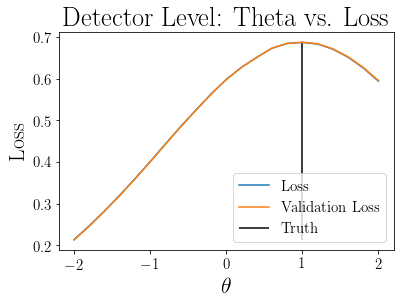

In [23]:
plt.plot(thetas, lvals_D, label='Loss')
plt.plot(thetas, vlvals_D, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D),
           ymax=np.max(lvals_D),
           label='Truth')
plt.title("Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [24]:
f = sp.interpolate.interp1d(thetas, lvals_D, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999943335718


### Comparison Plot

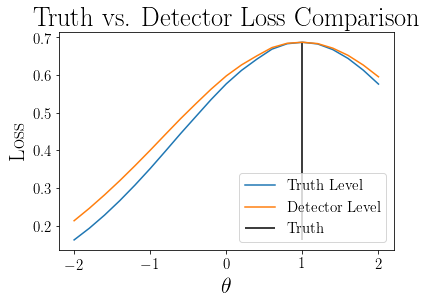

In [25]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Detector Level')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D),
           ymax=np.max(vlvals_T + vlvals_D),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison")
plt.legend()
# plt.savefig("GaussianAltFit-1D-Truth-vs-Detector-Loss-Comparison.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

## Fitting Model: Gradient Fit

### Creating Model

In [26]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    "Theta fit = ", model_fit.layers[-1].get_weights()[-1]))

theta_fit_init = 0
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [27]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=list(),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size_g = 1000
batch_size_theta = 2 * N
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________


### Truth Level Gradient Fit

In [28]:
def my_loss_wrapper_fit_T(
        inputs,
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_type='DCTR',
        loss='MSE',
        batch_size=1000):

    x = inputs
    x = K.gather(x, np.arange(batch_size))

    # Getting theta_prime and fixing batch size:
    if mysign == 1:
        #  when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()
    else:
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [29]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    # Reshuffling Training Data:
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
    X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass
    model_fit.layers[-1].trainable = False
    #     model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])
    
    print("Training g")
    model_fit.fit(np.array(X_train_T),
                  y_train_T,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_T), y_test_T),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          -1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_T),
                  y_train_theta_T,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) >= 6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================\n')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.49999213


Iteration:  2
Training g
Training theta
Theta fit =  0.87205076


Iteration:  3
Training g
Training theta
Theta fit =  1.1914169


Iteration:  4
Training g
Training theta
Theta fit =  0.9186913


Iteration:  5
Training g
Training theta
Theta fit =  1.1913813


Iteration:  6
Training g
Training theta
Theta fit =  0.93033993


Iteration:  7
Training g
Training theta
Theta fit =  1.183474


Iteration:  8
Training g
Training theta
Theta fit =  0.9356146


Iteration:  9
Training g
Training theta
Theta fit =  1.1799245


====Refining Learning Rate====

Iteration:  10
Training g
Training theta
Theta fit =  1.0331242


Iteration:  11
Training g
Training theta
Theta fit =  1.0090339


Iteration:  12
Training g
Training theta
Theta fit =  0.9849925


Iteration:  13
Training g
Training theta
Theta fit =  1.0089778


Iteration:  14
Training g
Training theta
Theta fit =  0.9848351


Iteration:  15
Training g
Training theta
Theta fit 

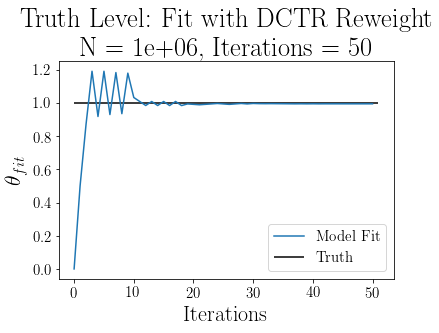

In [30]:
plt.title(
    "Truth Level: Fit with DCTR Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Truth-Level:-Fit-with-DCTR-Reweight\nN=:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

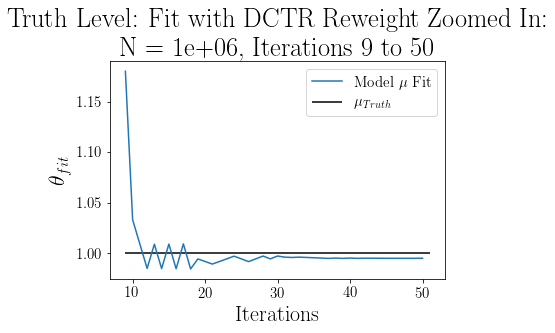

In [31]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "Truth Level: Fit with DCTR Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Truth-Level:-Fit-with-DCTR-Reweight-Zoomed-In:\nN={:.0e}-Iterations-{:.0f}to{:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting for Truth Level

In [32]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [33]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    # Reshuffling Training Data:
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    X_train_T, y_train_T = np.copy(X_train[:, 0]), y_train
    X_test_T, y_test_T = np.copy(X_test[:, 0]), y_test

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #     model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])
    
    print("Training g")
    model_fit.fit(np.array(X_train_T),
                  y_train_T,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_T), y_test_T),
                  verbose=0,
                  callbacks=[earlystopping])

    # Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_T(
                          myinputs_fit,
                          -1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()
    
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_T),
                  y_train_theta_T,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) >= 6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.49999207


Iteration:  2
Training g
Training theta
Theta fit =  0.87204933


Iteration:  3
Training g
Training theta
Theta fit =  1.1914275


Iteration:  4
Training g
Training theta
Theta fit =  0.90088344


Iteration:  5
Training g
Training theta
Theta fit =  1.1735928


Iteration:  6
Training g
Training theta
Theta fit =  0.91255367


Iteration:  7
Training g
Training theta
Theta fit =  1.165707


Iteration:  8
Training g
Training theta
Theta fit =  0.9178494


Iteration:  9
Training g
Training theta
Theta fit =  1.1621883


====Refining Learning Rate====
Iteration:  10
Training g
Training theta
Theta fit =  1.0153621


Iteration:  11
Training g
Training theta
Theta fit =  0.9912781


Iteration:  12
Training g
Training theta
Theta fit =  1.0153122


Iteration:  13
Training g
Training theta
Theta fit =  0.9912413


Iteration:  14
Training g
Training theta
Theta fit =  1.0153933


Iteration:  15
Training g
Training theta
Theta fit 

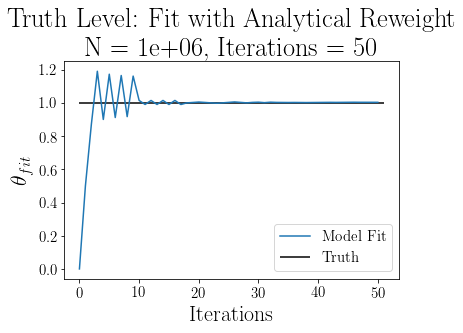

In [34]:
plt.title(
    "Truth Level: Fit with Analytical Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Truth-Level:-Fit-with-Analytical-Reweight\nN=:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

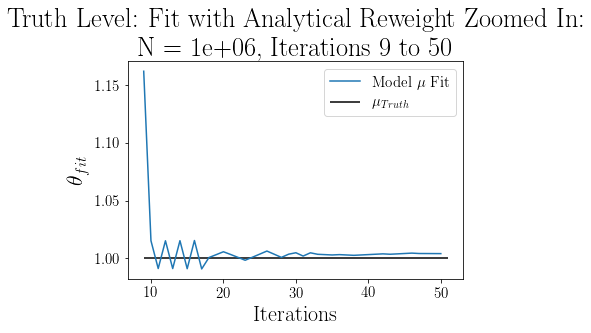

In [35]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "Truth Level: Fit with Analytical Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Truth-Level:-Fit-with-Analytical-Reweight-Zoomed-In:\nN={:.0e}-Iterations-{:.0f}to{:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()

### Detector Level Gradient Fit

In [36]:
def my_loss_wrapper_fit_D(
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_type='DCTR',
        loss='MSE',
        batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss

        # Getting theta_prime:
        if mysign == 1:
            # when not training theta, fetch as np array
            theta_prime = model_fit.layers[-1].get_weights()

        else:
            # when trainingn theta, fetch as tf.Variable
            theta_prime = model_fit.trainable_weights[-1]

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = mysign*(y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2)
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign*((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [37]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [38]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    # Reshuffling Training data
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    #'Erasing' Truth level for data, we can't actually observe this
    X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
    X_train_theta[:, 0][y_train_theta == 1] = 0.

    # 'hiding' truth level for simulation in model output (used in reweighting)
    X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                                   axis=1)
    X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_D(
                          1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_D),
                  y_train_D,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_D), y_test_D),
                  verbose=0,
                  callbacks=[earlystopping])

    # Now, fix g and train \theta.
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_D(
                          -1,
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta_D),
                  y_train_theta_D,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)

    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) == 0
        ):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.4999904


Iteration:  2
Training g
Training theta
Theta fit =  0.87204725


Iteration:  3
Training g
Training theta
Theta fit =  1.1914017


Iteration:  4
Training g
Training theta
Theta fit =  0.9008622


Iteration:  5
Training g
Training theta
Theta fit =  1.1735406


Iteration:  6
Training g
Training theta
Theta fit =  0.91250503


Iteration:  7
Training g
Training theta
Theta fit =  1.1656277


Iteration:  8
Training g
Training theta
Theta fit =  0.91777474


Iteration:  9
Training g
Training theta
Theta fit =  1.1620846


====Refining Learning Rate====
Iteration:  10
Training g
Training theta
Theta fit =  1.0152917


Iteration:  11
Training g
Training theta
Theta fit =  0.9912022


Iteration:  12
Training g
Training theta
Theta fit =  0.96725833


Iteration:  13
Training g
Training theta
Theta fit =  0.99133193


Iteration:  14
Training g
Training theta
Theta fit =  0.9672302


Iteration:  15
Training g
Training theta
Theta fi

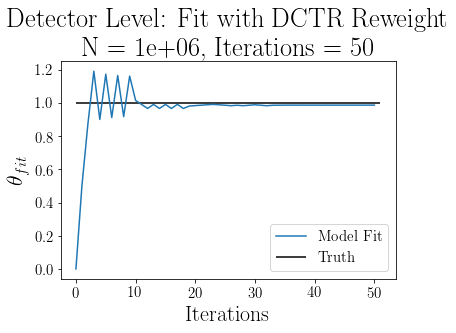

In [39]:
plt.title(
    "Detector Level: Fit with DCTR Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Detector-Level:-Fit-with-DCTR-Reweight\nN=:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

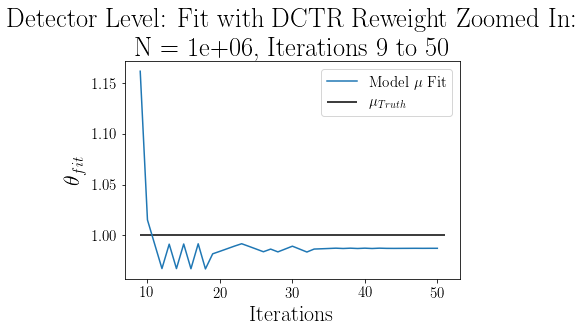

In [40]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "Detector Level: Fit with DCTR Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Detector-Level:-Fit-with-DCTR-Reweight-Zoomed-In:\nN={:.0e}-Iterations-{:.0f}to{:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting for Detector Level

In [41]:
# Reset parameters

fit_vals = [theta_fit_init]
model_fit.layers[-1].set_weights(np.array([theta_fit_init]))
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [42]:
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)
    # Reshuffling Training data
    X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                        yvals,
                                                        test_size=0.5)

    #'Erasing' Truth level for data, we can't actually observe this
    X_train[:, 0][y_train == 1], X_test[:, 0][y_test == 1] = 0., 0.
    X_train_theta[:, 0][y_train_theta == 1] = 0.

    # 'hiding' truth level for simulation in model output (used in reweighting)
    X_train_D, y_train_D = X_train[:, 1], np.stack([y_train, X_train[:, 0]],
                                                   axis=1)
    X_test_D, y_test_D = X_test[:, 1], np.stack([y_test, X_test[:, 0]], axis=1)

    # fix \theta and train g
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #     model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer='Adam',
                      loss=my_loss_wrapper_fit_D(
                          1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_g),
                      metrics=['accuracy'])

    print("Training g")
    model_fit.fit(np.array(X_train_D),
                  y_train_D,
                  epochs=100,
                  batch_size=batch_size_g,
                  validation_data=(np.array(X_test_D), y_test_D),
                  verbose=0,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.
    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit_D(
                          -1,
                          reweight_type='analytical',
                          loss='categorical_crossentropy',
                          batch_size=batch_size_theta),
                      metrics=['accuracy'])
    #     model.summary()

    print("Training theta")
    model_fit.fit(np.array(X_train_theta_D),
                  y_train_theta_D,
                  epochs=1,
                  batch_size=batch_size_theta,
                  verbose=0,
                  callbacks=callbacks)
    
    print("\n")

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    if (len(extrema) == 0
        ):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema) >= 6):  # If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.

        mean_fit = np.array([
            np.mean(fit_vals_recent[len(fit_vals_recent) -
                                    4:len(fit_vals_recent)])
        ])

        model_fit.layers[-1].set_weights(mean_fit)
    pass

Iteration:  1
Training g
Training theta
Theta fit =  0.4999904


Iteration:  2
Training g
Training theta
Theta fit =  0.87204564


Iteration:  3
Training g
Training theta
Theta fit =  1.1914142


Iteration:  4
Training g
Training theta
Theta fit =  0.90087557


Iteration:  5
Training g
Training theta
Theta fit =  1.1735777


Iteration:  6
Training g
Training theta
Theta fit =  0.91254306


Iteration:  7
Training g
Training theta
Theta fit =  1.1656876


Iteration:  8
Training g
Training theta
Theta fit =  0.91783524


Iteration:  9
Training g
Training theta
Theta fit =  1.1621654


====Refining Learning Rate====
Iteration:  10
Training g
Training theta
Theta fit =  1.0153471


Iteration:  11
Training g
Training theta
Theta fit =  0.99128145


Iteration:  12
Training g
Training theta
Theta fit =  1.0153197


Iteration:  13
Training g
Training theta
Theta fit =  0.99124163


Iteration:  14
Training g
Training theta
Theta fit =  1.0153855


Iteration:  15
Training g
Training theta
Theta f

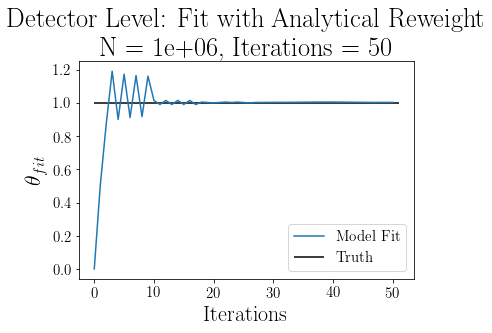

In [43]:
plt.title(
    "Detector Level: Fit with Analytical Reweight\nN = {:.0e}, Iterations = {:.0f}".
    format(N, iterations))
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Detector-Level:-Fit-with-Analytical-Reweight\nN=:.0e}-Iterations={:.0f}.png"
#     .format(N, iterations))
plt.show()

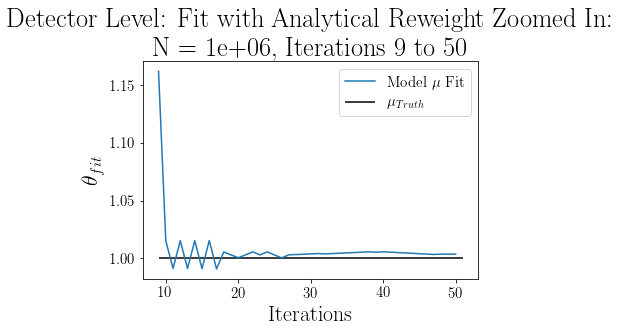

In [44]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "Detector Level: Fit with Analytical Reweight Zoomed In:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D-Detector-Level:-Fit-with-Analytical-Reweight-Zoomed-In:\nN={:.0e}-Iterations-{:.0f}to{:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()